In [4]:
import pickle
from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np

import pandas as pd

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from theano import shared
import theano.tensor as tt
import pymc3 as pm
from tqdm import tqdm

import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, heatmap, kdeplot
import cmocean.cm as cmo
import pymc_utils

In [2]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [3]:
tqdm.monitor_interval = 0

In [34]:
def hier_lasso_regr(X, y_obs, add_bias=True, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlasso:
        hyp_beta = pm.HalfCauchy('hyp_beta', beta=2.5)
        hyp_mu = pm.HalfCauchy('hyp_mu', mu=0, beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        alpha = pm.Laplace('alpha', mu=hyp_mu, b=hyp_beta)
        w = pm.Laplace('w', mu=hyp_mu, b=hyp_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mlasso

def robust_hier_lasso_regr(X, y_obs, add_bias=True, ylabel='y'):
    num_obs, num_feats = X.shape
    with pm.Model() as mlasso:
        hyp_beta = pm.HalfCauchy('hyp_beta', beta=2.5)
        hyp_mu = pm.HalfCauchy('hyp_mu', mu=0, beta=2.5)
        sig = pm.HalfCauchy('sigma', beta=2.5)
        nu_ = pm.HalfCauchy('nu', beta=2.5)
        alpha = pm.Laplace('alpha', mu=hyp_mu, b=hyp_beta)
        w = pm.Laplace('w', mu=hyp_mu, b=hyp_beta, shape=num_feats)
        mu_ = pm.Deterministic('mu', alpha + tt.dot(X, w))
        y = pm.StudentT('y', mu=mu_, nu=nu_, sd=sig, observed=y_obs.squeeze())
    return mlasso


In [49]:
df_aphy = pd.read_pickle('./pickleJar/df_3_ML4aphy.pkl')

In [51]:
df_aphy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 0 to 494
Data columns (total 33 columns):
oisst            495 non-null float64
etopo2           495 non-null float64
sola             495 non-null float64
solz             495 non-null float64
sat_rho_rc412    495 non-null float64
sat_rho_rc443    495 non-null float64
sat_rho_rc490    495 non-null float64
sat_rho_rc510    495 non-null float64
sat_rho_rc555    495 non-null float64
sat_rho_rc670    495 non-null float64
datetime         495 non-null datetime64[ns]
lat              495 non-null float64
lon              495 non-null float64
aphy405          495 non-null float64
aphy411          495 non-null float64
aphy443          495 non-null float64
aphy455          495 non-null float64
aphy465          495 non-null float64
aphy489          495 non-null float64
aphy510          495 non-null float64
aphy520          495 non-null float64
aphy530          495 non-null float64
aphy550          495 non-null float64
aphy555       

In [31]:
def PlotPairGrid(df, hue_kwd, data_cols, map_lower=True):
    g = PairGrid(ds, hue=hue_kwd, vars=data_cols)
    g.map_upper(pl.scatter, alpha=0.7, edgecolor='k')
    g.map_diag(kdeplot)
    if map_lower:
        g.map_lower(kdeplot)
    g.add_legend()
    return g

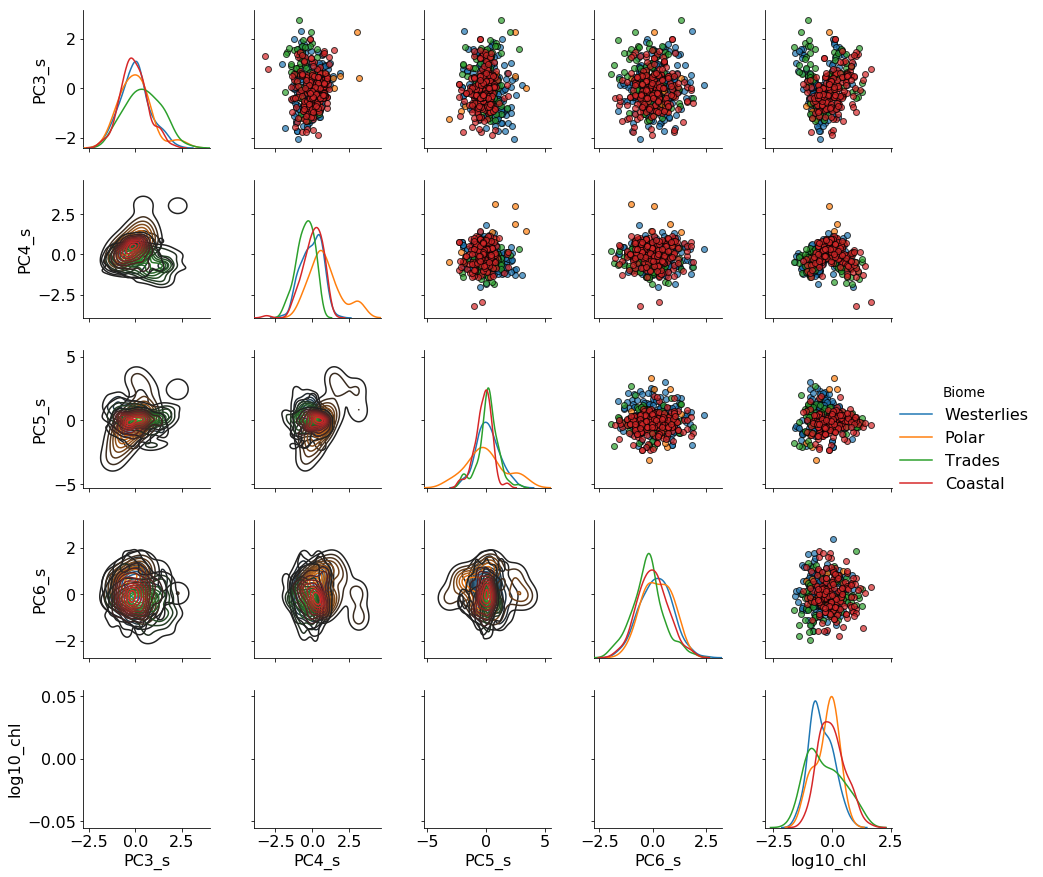

In [21]:
data_cols = ds.loc[:, 'PC3_s': ].columns.tolist()
PlotPairGrid(ds, hue_kwd="Biome", data_cols=data_cols);

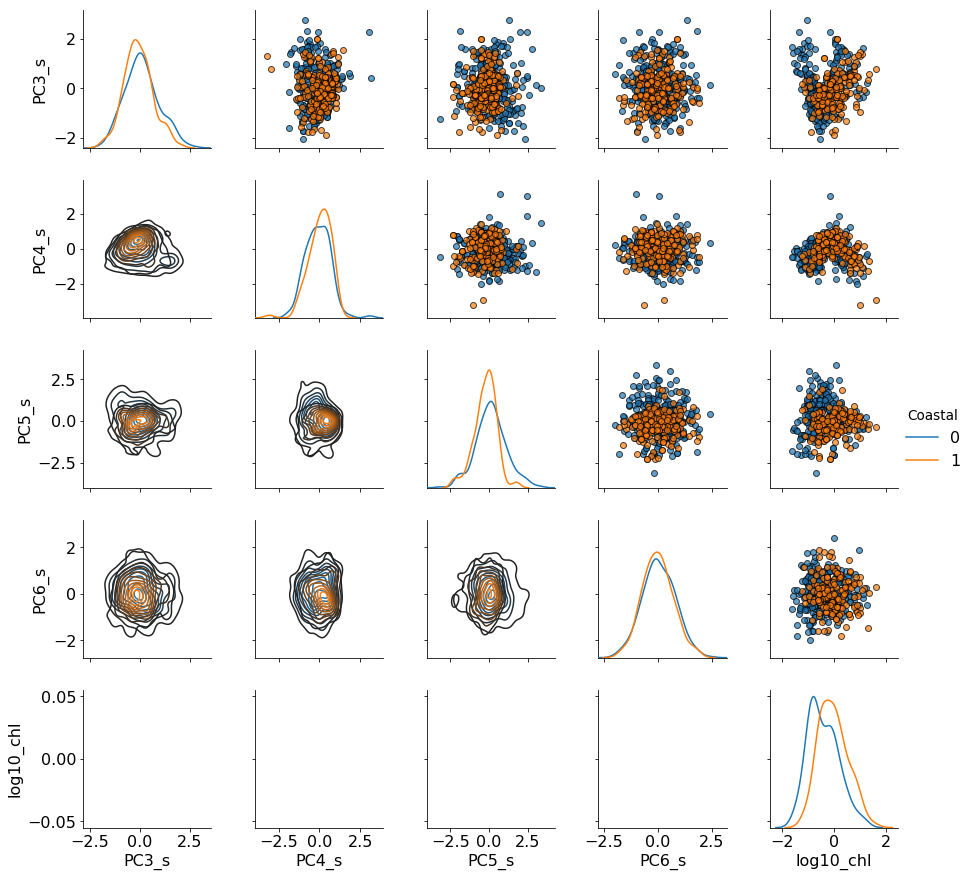

In [23]:
data_cols = ds.loc[:, 'PC3_s': ].columns.tolist()
PlotPairGrid(ds, hue_kwd='Coastal', data_cols=data_cols);

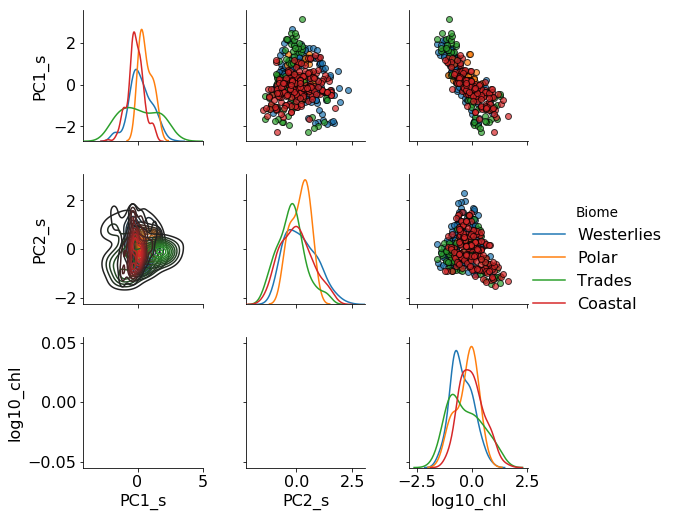

In [24]:
data_cols = ['PC%d_s' %i for i in range(1, 3)] + ['log10_chl']
PlotPairGrid(ds, hue_kwd='Biome', data_cols=data_cols);

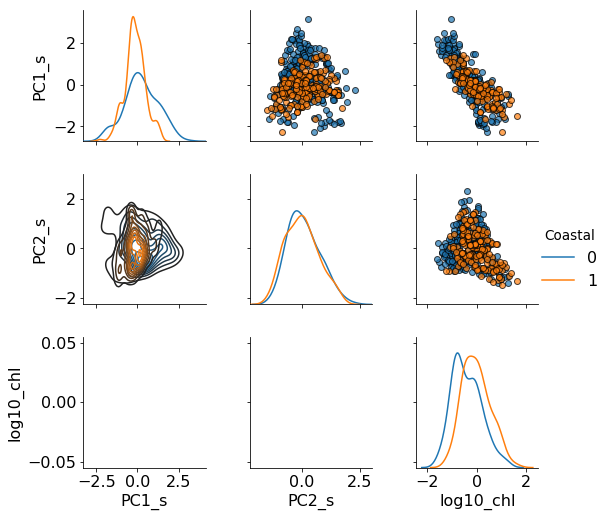

In [25]:
data_cols = ['PC%d_s' %i for i in range(1, 3)] + ['log10_chl']
PlotPairGrid(ds, hue_kwd='Coastal', data_cols=data_cols);

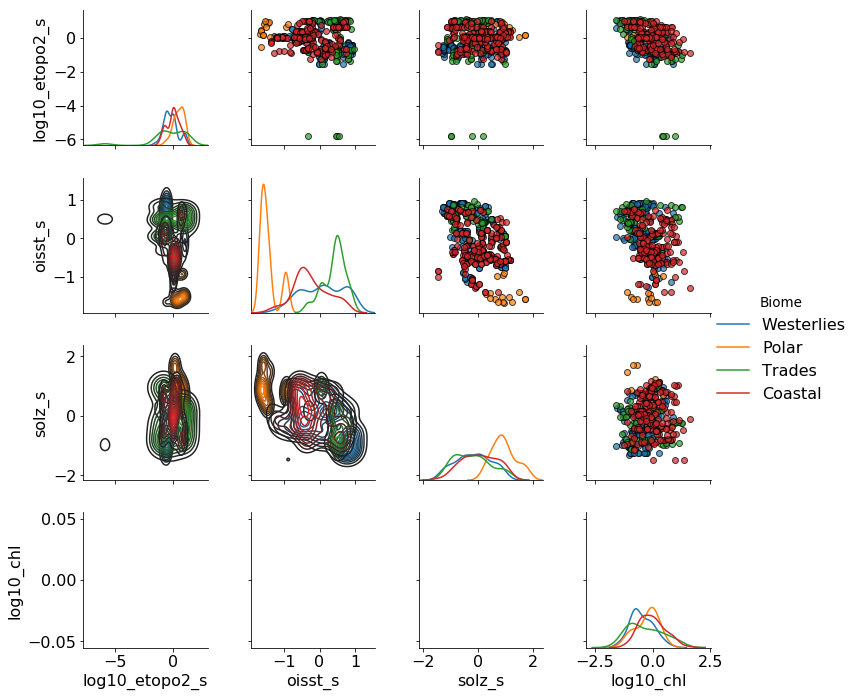

In [28]:
data_cols = ds.loc[:,'log10_etopo2_s': 'solz_s'].columns.tolist() + ['log10_chl']
PlotPairGrid(ds, hue_kwd='Biome', data_cols=data_cols);

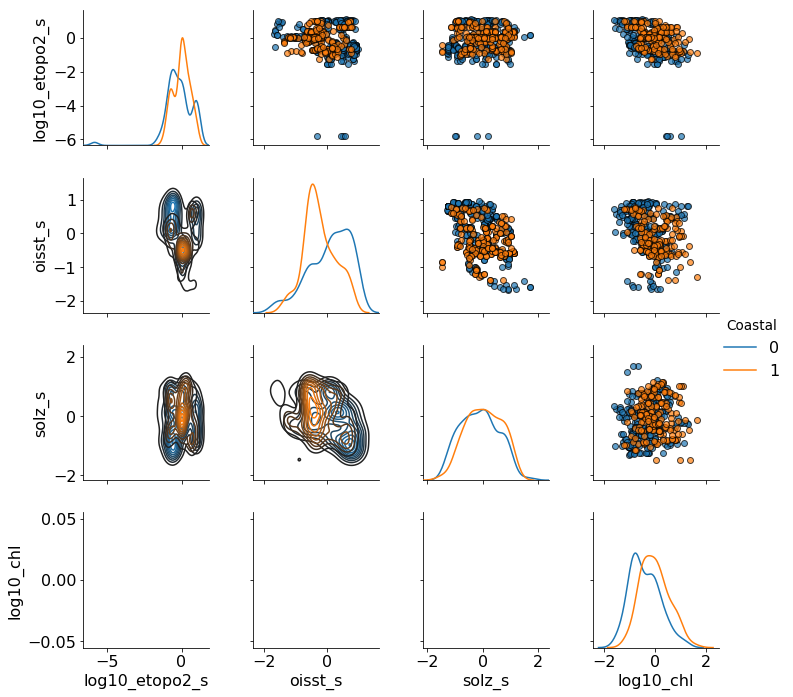

In [29]:
PlotPairGrid(ds, hue_kwd='Coastal', data_cols=data_cols);

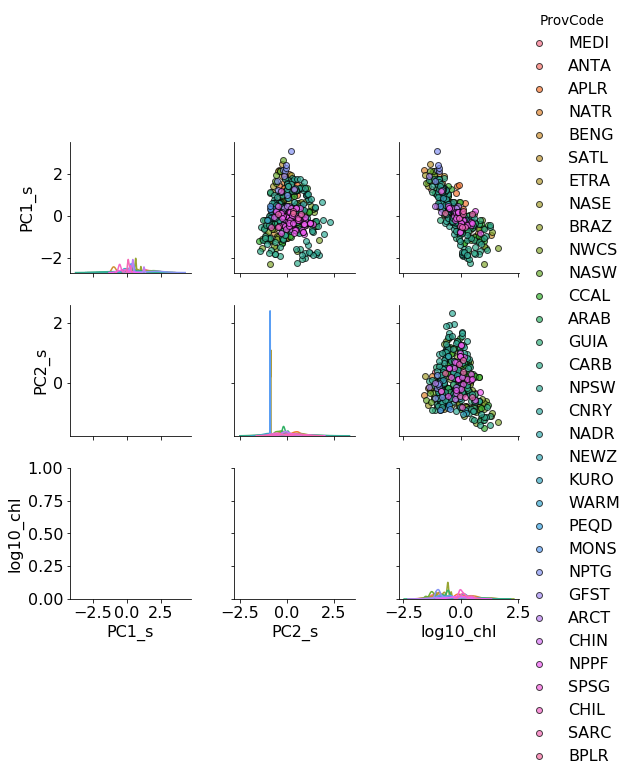

In [32]:
data_cols = ['PC%d_s' %i for i in range(1, 3)] + ['log10_chl']
PlotPairGrid(ds, hue_kwd='ProvCode', data_cols=data_cols, map_lower=False);

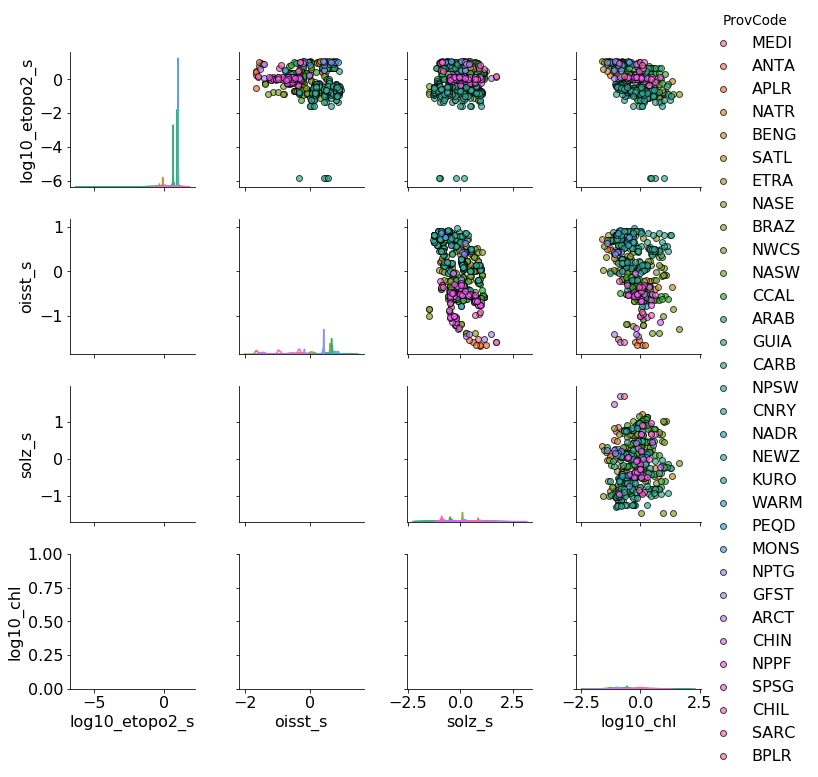

In [33]:
data_cols = ds.loc[:,'log10_etopo2_s': 'solz_s'].columns.tolist() + ['log10_chl']
PlotPairGrid(ds, hue_kwd='ProvCode', data_cols=data_cols, map_lower=False);